## Binary graph noise reduction with Markov random field (MRF) and Ising Model

Original Image             |  10% salt and pepper noise added
:-------------------------:|:-------------------------:
<img src="in.png">  |  <img src="flipped.png">


Let's define:
- $y_i$ pixel in noise image
- $x_i$ pixel in the original image, corresponding to y in the noise image

A priori knowledge:

    1) strong connection between $x_i$ and $y_i$; if we fix $y$ as prior knowledge, the prob. we seek becomes $p(x|y)$: _Ising Model_

    2) strong connection of $x_i$ with other pixels adjacent to it; assume original pixel is only related to its directly adjacent pixels (Conditional independence property) -> partial Markov property (Local Markov property):

<img src="mrf_denoising.png">

Two groups (cliques):

- {$x_i$, $y_i$}: pixel pair of the original image and the noise image
- {$x_i$, $x_j$}: adjacent pixels to $x_i$

__Joint probability distribution__ based on the markov blanket $\mathbf{x}_C = {x_i, x_j, y_i}$: $p(\mathbf{x}) = \frac{\prod_C p_C{(\mathbf{x}_C)}}{\sum_\mathbf{x} \prod_C \phi_C{(\mathbf{x}_C)}} = \frac{1}{Z}\prod_C \phi_C(\mathbf{x}_C)$


__potential function__: $\phi_C(\mathbf{x}_C)= exp{(-E(\mathbf{x}_C))}$

With $E(\mathbf{x}_C)$ as _energy function_. In the process of noise reduction, the _lower_ the energy, the _greater_ the joint probability P(X=x) (the probability that the noise-reduced image is consistent with the original image).

Because we need to deal with binary graphs, first we define $x_i \in {-1, +1}$, assuming here that white is 1, and black is -1.

- for {$x_i$,$y_i$} we define: $\eta * x_i y_i$ with $\eta \geq 0$; if both are the same: $-\eta$ otherwise $\eta$
- for {$x_i$,$x_j$} we define: $\beta * x_i x_j$ with $\beta \geq 0$; if both are the same: $-\beta$ otherwise $\beta$

Finally, we define another term: $h * x_i$ to bias the entire processed image to a certain pixel value.

$E(\mathbf{x},\mathbf{y}) = h \sum_i x_i - \eta \sum_{i} x_i y_i - \beta \sum_{i,j} x_i x_j$




In [1]:
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

In [2]:
def E_generator(beta, eta, h):
    """Generate energy function E.

    Usage: E = E_generator(beta, eta, h)
    Formula:
        E = h * \sum{x_i} - beta * \sum{x_i x_j} - eta * \sum{x_i y_i}
    """
    def E(x, y):
        """Calculate energy for matrices x, y.

        Note: the computation is not localized, so this is quite expensive.
        """
        # sum of products of neighboring paris {xi, yi}
        xxm = np.zeros_like(x)
        xxm[:-1, :] = x[1:, :]  # down
        xxm[1:, :] += x[:-1, :]  # up
        xxm[:, :-1] += x[:, 1:]  # right
        xxm[:, 1:] += x[:, :-1]  # left
        xx = np.sum(xxm * x)
        xy = np.sum(x * y)
        xsum = np.sum(x)
        return h * xsum - beta * xx - eta * xy
    
    def is_valid(i, j, shape):
        """Check if coordinate i, j is valid in shape."""
        return i >= 0 and j >= 0 and i < shape[0] and j < shape[1]
    
    def localized_E(E1, i, j, x, y):
        """Localized version of Energy function E.

        Usage: old_x_ij, new_x_ij, E1, E2 = localized_E(Ecur, i, j, x, y)
        """
        oldval = x[i, j]
        newval = oldval * -1  # flip
        # local computations
        E2 = E1 - (h * oldval) + (h * newval)
        E2 = E2 + (eta * y[i, j] * oldval) - (eta * y[i, j] * newval)
        adjacent = [(0, 1), (0, -1), (1, 0), (-1, 0)]
        neighbors = [x[i + di, j + dj] for di, dj in adjacent
                     if is_valid(i + di, j + dj, x.shape)]
        E2 = E2 + beta * sum(a * oldval for a in neighbors)
        E2 = E2 - beta * sum(a * newval for a in neighbors)
        return oldval, newval, E1, E2
    return E, localized_E

### Iterated Conditional Modes (ICM)    
Julian Besag Papers in 1986On the Statistical Analysis of Dirty Pictures Proposed in the paper

    1) Let's initialize $\mathbf{x} to \mathbf{y}$
    2) traverse each element and try the two states {-1,1}
    3) choose the one state with higher total energy (_greedy strategy_)
    
Because each step of the ICM actually fixes other elements and only changes the element currently traversed, we can localize the calculation of E and recalculate only the small area affected.

In [3]:
def ICM(y, E, localized_E):
    """Greedy version of simulated_annealing()."""
    x = np.array(y)
    Ebest = Ecur = E(x, y)  # initial energy
    initial_time = time.time()
    energy_record = [[0.0, ], [Ebest, ]]

    accept, reject = 0, 0
    for idx in np.ndindex(y.shape):  # for each pixel in the matrix
        old, new, E1, E2 = localized_E(Ecur, idx[0], idx[1], x, y)
        if (E2 < Ebest):
            Ecur, x[idx] = E2, new
            Ebest = E2  # update Ebest
        else:
            Ecur, x[idx] = E1, old

    # record time and Ebest of this iteration
    end_time = time.time()
    energy_record[0].append(end_time - initial_time)
    energy_record[1].append(Ebest)

    return x, energy_record

In [4]:
def sign(data, translate):
    """Map a dictionary for the element of data.

    Example:
        To convert every element in data with value 0 to -1, 255 to 1,
        use `signed = sign(data, {0: -1, 255: 1})`
    """
    temp = np.array(data)
    return np.vectorize(lambda x: translate[x])(temp)

In [5]:
beta, eta, h = 1e-3, 2.1e-3, 0.0

In [6]:
original = Image.open('in.png')
im = Image.open('flipped.png')

In [7]:
data = sign(im.getdata(), {0: -1, 255: 1})  # convert to {-1, 1}
y = data.reshape(im.size[::-1]) # to matrix

In [8]:
E, localized_E = E_generator(beta, eta, h)

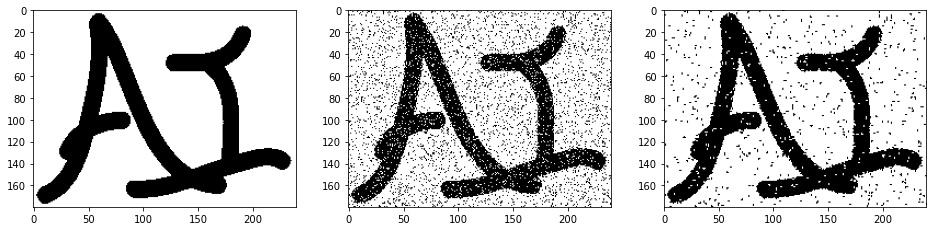

In [9]:
result, energy_record = ICM(y, E, localized_E)
result = sign(result, {-1: 0, 1: 255})
output_image = Image.fromarray(result.astype(np.uint8)).convert('1', dither=Image.NONE)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,12))

ax1.imshow(np.asarray(original), cmap = 'gray')
ax2.imshow(np.asarray(im), cmap = 'gray')
ax3.imshow(result, cmap = 'gray')

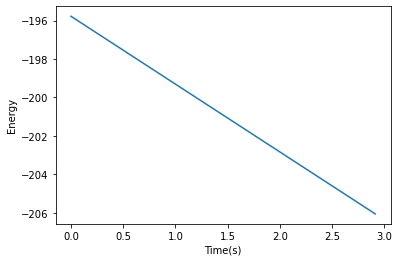

In [10]:
plt.plot(*energy_record)
plt.xlabel('Time(s)')
plt.ylabel('Energy')
plt.show()

In [11]:
x = np.reshape(im.getdata(), im.size[::-1])
1 - np.count_nonzero(x - result) / float(x.size)

0.9365740740740741

In [12]:
x = np.reshape(original.getdata(), original.size[::-1])
1 - np.count_nonzero(x - result) / float(x.size)

0.9621064814814815